In [ ]:
%env CUDA_VISIBLE_DEVICES=6
# Standard libraries
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from typing import Sequence
# jax
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import lax

## JAX
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax
    

In [2]:
rng = jax.random.PRNGKey(42)

2022-12-21 14:01:47.386680: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:492] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


CPU times: user 54 ms, sys: 22.9 ms, total: 76.9 ms
Wall time: 125 ms


<AxesSubplot:>

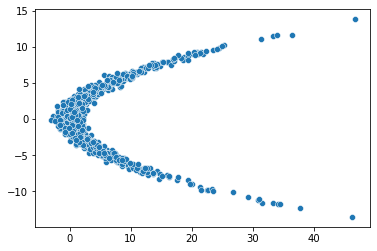

In [3]:
%%time
# get points with numpy 
def get_points():
    x2 = 0 + 4 * np.random.normal()
    x1 = 0.25 * x2**2 + np.random.normal()
    return x1,x2
x_samples = np.array([get_points() for i in range(1000)])
sns.scatterplot(x = x_samples[:,0],y = x_samples[:,1])

CPU times: user 1.2 s, sys: 388 ms, total: 1.59 s
Wall time: 2.13 s


<AxesSubplot:>

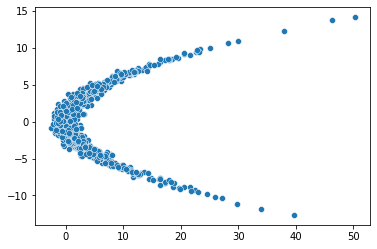

In [4]:
%%time
def get_points(rng):
    r1,r2 = jax.random.split(rng,num=2)
    x2 = 0 + 4 * jax.random.normal(r1)
    x1 = 0.25 * x2**2 + jax.random.normal(r2)
    return x1,x2

rng, *rngs = jax.random.split(rng,num=1000)
get_points_jit = jit(get_points)

x_samples = vmap(get_points_jit)(jnp.array(rngs))

sns.scatterplot(x = x_samples[0],y = x_samples[1])


<AxesSubplot:>

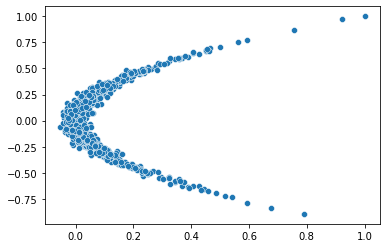

In [5]:
X = x_samples[0]/x_samples[0].max()
Y = x_samples[1]/x_samples[1].max()
sns.scatterplot(x = X,y = Y)

<AxesSubplot:>

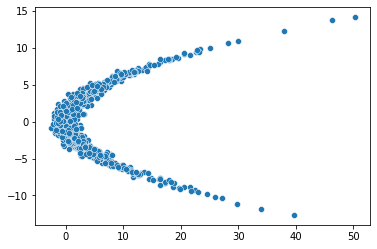

In [6]:
# either way, the data is stored in d
d = jnp.stack(x_samples,axis=1)
sns.scatterplot(x=d[:,0],y=d[:,1])

### implementing the base distribution, which we want to transform

<AxesSubplot:>

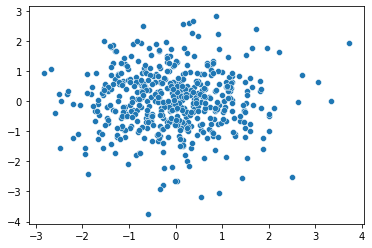

In [7]:
# this is our base distribtion, which we aim to map onto the target distribution
cov = np.array([[1, 0], [0, 1]])
mean = np.array([0,0])

base_dist = jax.random.multivariate_normal(rng,mean,cov,shape=(512,))
sns.scatterplot(x=base_dist [:,0],y=base_dist [:,1])

#### looks like jax is much slower than numpy in sample generation I wonder why?


### leaky relu

In [15]:
alpha = 0.5
class LeakyRelu(nn.Module):
    alpha : float
    def __call__(self, z, ldj=0, reverse=False):
        if not reverse:
            z = jnp.where(z>0, z, self.alpha * z)
            ldj += 0
            return z, ldj
        else:
            z = jnp.where(z>0, z, z/self.alpha)
            ldj 
            return z, ldj

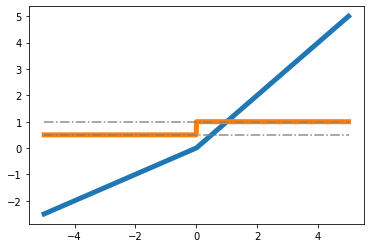

In [16]:
LRU = LeakyRelu(alpha)
x = np.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
y,ldj = LRU(x)
y_grads = jax.grad(lambda inp: LRU(inp)[0].sum())(x) # we cant directy do jax.grad because relu outputs 2 values
plt.plot(x,y,label="ActFn",linewidth=5,)
plt.plot(x,y_grads,label="gradient",linewidth=5,)
plt.plot(x,[alpha]*len(x),'-.',alpha=0.9,color="grey")
plt.plot(x,[1]*len(x),'-.',alpha=0.9,color="grey")

# Converting distributions using the rule p(x) = p(z)dz/dx
- We have x ~ p(x)
- we have f(x) = z
- we want p(z) such that z ~ p(z)

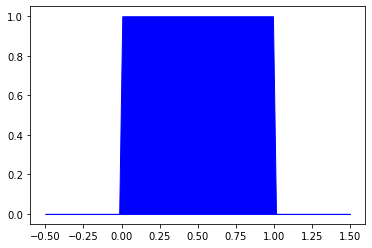

In [10]:
# scipy has a base class for continuous distributions
# let's say we have a valid probability distribution where x is between [0,1] and p(x) = 1 

from scipy.stats import rv_continuous

class x_dist(rv_continuous):
    def _pdf(self, x):
        return np.where((x>0) & (x<1),1,0)
    
px = x_dist()
x = np.linspace(-0.5,1.5,100)
plt.fill_between(x,px.pdf(x),color="blue")

In [11]:
def fn(x, reverse = False):
    if reverse:
        return x/2 - 1
    else:
        return 2*x + 1

# how does the transformation affect z ~ p(z)
1. p(z) = p(x) * dx/dz  
2. p(z) = p(x) * d(f-1(z))/d(z)
3. p(z) = p(x) * d(z/2 - 1)/d(z)
4. p(z) = p(x) * 1/2

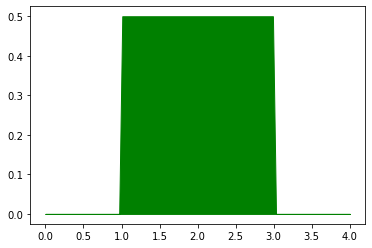

In [12]:
# now we know that if x is being projected by f(x), then px will be projected by 1/2
# f(x) = z
# 0.5*px = pz
# so the new distibutions will looks like this: 
z = fn(x)
pz = 0.5 * px.pdf(x)
plt.fill_between(z,pz,color = "g")

# Now let's do the same thing in 2D

In [13]:
from scipy.stats import multivariate_normal, norm

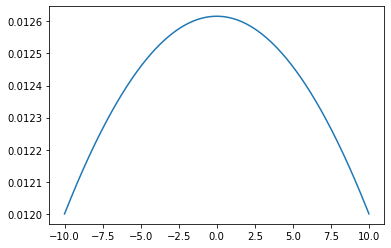

In [14]:
x = np.linspace(-10,10,10000,endpoint=False)
y = multivariate_normal.pdf(x,mean=0,cov=1000)
plt.plot(x,y)

In [ ]:
rv = multivariate_normal(mean=None, cov=1)
x, y = np.mgrid[-1:1:.01,-1:1:0.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
plt.contourf(x,y,rv.pdf(pos))